Use bigger network

Experiment with mutation

convolution -> output probabilities for rsb to take from


In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
%run imports.py

In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [175]:

def check_mutations(net, n_mut=10, n_samples=None):
    vec = util.model2vec(net).detach()
    data = []
    for mut_idx in range(n_mut):
        nvec = vec+1e-2*torch.randn_like(vec)
        net = util.vec2model(nvec, net)
        
        fitdata = task.calc_pheo_fitness(net, n_sample=n_samples, device=device)
        data.append(fitdata)
    net = util.vec2model(vec, net)
    return data
    

n_trials, n_epochs, n_muts, n_samples = 10, 15, 50, None

before_mut = np.empty((n_trials, n_epochs), dtype=object)
after_mut = np.empty((n_trials, n_epochs, n_muts), dtype=object)
torch.manual_seed(13)
np.random.seed(13)
model = models_pheno.SmallNet

for trial_idx in tqdm(range(n_trials)):
    net = model().to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-2)
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
        for X_batch, Y_batch in zip([task.X_train[10000*i:10000*(i+1)] for i in range(6)], [task.Y_train[10000*i:10000*(i+1)] for i in range(6)]):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)
            loss = task.loss_func(Y_batch_pred, Y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

        before_mut[trial_idx, epoch_idx] = task.calc_pheo_fitness(net, n_sample=n_samples, device=device)
        after_mut[trial_idx, epoch_idx, :] = check_mutations(net, n_muts, n_samples=n_samples)
        loop.set_postfix(before_mut[trial_idx, epoch_idx])


In [176]:
before_mut = np.array(before_mut)
after_mut = np.array(after_mut)
bef = util.arr_dict2dict_arr(before_mut)['loss']
aft = util.arr_dict2dict_arr(after_mut)['loss']
diff = aft-bef[..., None]

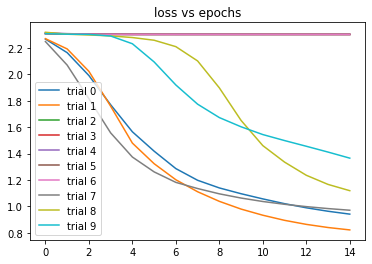

In [177]:
for trial_idx, data in enumerate(bef):
    plt.plot(data, label=f'trial {trial_idx}')
plt.title('loss vs epochs'); plt.legend()
# plt.axhline(torch.load('./data/mnist_sgd_eval')[model]['loss'])
plt.show()

No handles with labels found to put in legend.


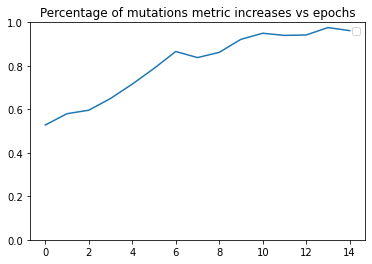

(10, 15, 50)

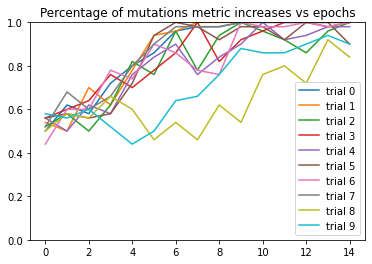

In [178]:
plt.plot(((diff>0).sum(axis=-1)/diff.shape[-1]).mean(axis=0))
plt.title('Percentage of mutations metric increases vs epochs')
plt.ylim(0,1);plt.legend()
plt.show()
for trial_idx, data in enumerate(diff):
    data = (data>0).sum(axis=-1)/data.shape[-1]
    plt.plot(data, label=f'trial {trial_idx}')
plt.title('Percentage of mutations metric increases vs epochs')
plt.ylim(0,1);plt.legend()
diff.shape

In [ ]:
X = task.X_train[:1000].reshape(-1, 28*28)
Y = task.Y_train[:1000]
Xp = sklearn.manifold.TSNE(2).fit_transform(X.cpu().numpy())
for i in tqdm(range(10)):
    plt.scatter(*Xp[Y==i].T, label=f'{i}')
plt.legend()
plt.show()

In [66]:
def evalaute_mutation_efficiency(model, v_init=None, n=1000, perturb_func=util.perturb_type1, 
                                 device='cpu', **kwargs):
    net = model().to(device)
    metric = 'accuracy'
    if v_init is not None: # I have a v to use
        net = util.vec2model(v_init, net)
        fit_init = task.calc_pheo_fitness(net, device=device)[metric]
        
    fits_init, fits_after, nvs = [], [], []
    for _ in tqdm(range(n)):
        net = model().to(device)
        if v_init is None: #randomly sample init
            fit_init = task.calc_pheo_fitness(net, device=device)[metric]
            v = util.model2vec(net)
        else:
            v = v_init
        
        nv = perturb_func(v, **kwargs)
        nvs.append(nv)
        
        fit_after = task.calc_pheo_fitness(util.vec2model(nv.detach(), net), device=device)[metric]
        fits_init.append(fit_init)
        fits_after.append(fit_after)
    fits_init, fits_after = np.array(fits_init), np.array(fits_after)
    nv_optimal = nvs[np.argmax(fits_after)]
    fits_diff = np.sort(fits_after-fits_init)

    plt.figure(figsize=(20,5))
    plt.subplot(131); plt.scatter(fits_init, fits_after); plt.plot(fits_init, fits_init, c='r')
    a = [np.min(fits_after), np.max(fits_after)]
    plt.plot(a, a, c='k')
    plt.title('Perturbed Fitness vs Init Fitness')
    plt.subplot(132); plt.plot(fits_diff); plt.axhline(c='k')
    plt.title('Sorted Change in Fitness')
    plt.subplot(133); plt.hist(fits_diff, bins=100); plt.axvline(c='k')
    plt.title('Change in Fitness')
    plt.show()
    print((fits_after>fits_init).sum()/len(fits_after)*100, '%')
    return nv_optimal
    


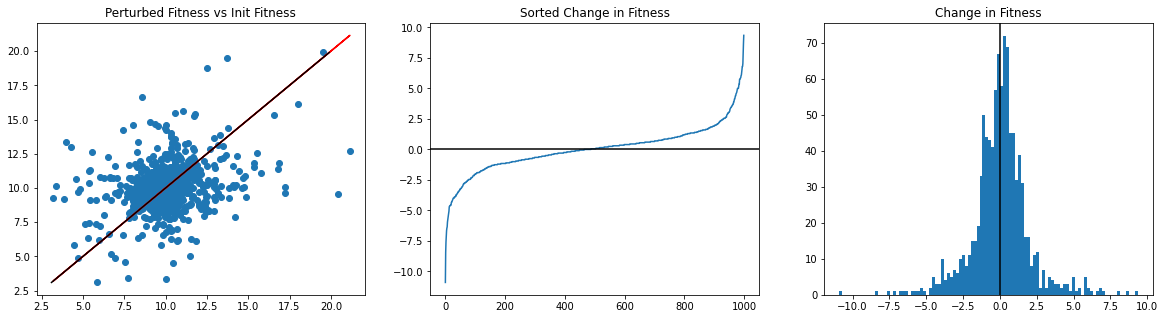

51.2 %


In [12]:
# evalaute_mutation_efficiency(models_pheno.SmallNet, n=1000, device=device, lr=1e-3)
evalaute_mutation_efficiency(models_pheno.SmallNet, n=1000, device=device,
                             perturb_func=util.perturb_type2, prob=0.2)

In [67]:
v = torch.load('./data/mnist_sgd_weights')[models_pheno.SmallNet].detach()

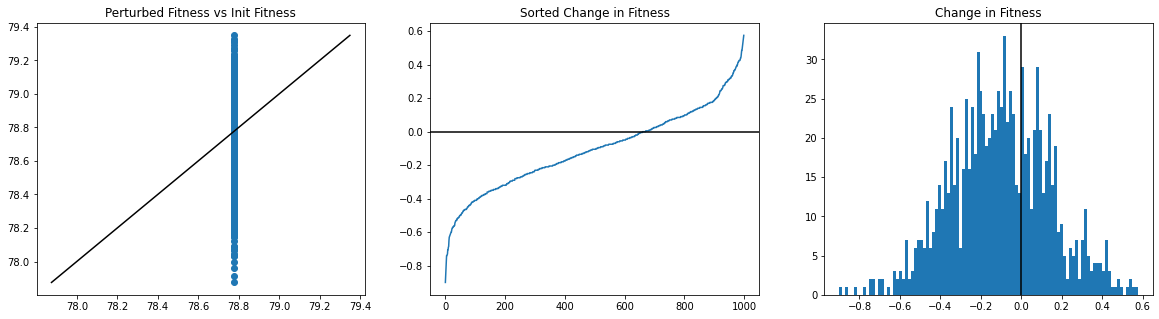

32.9 %


In [77]:
nv = evalaute_mutation_efficiency(models_pheno.SmallNet, v_init=v, n=1000, device=device, lr=1e-3)

In [78]:
net = util.vec2model(v, models_pheno.SmallNet().to(device))
task.perform_stats(net, loader=task.loader_train, tqdm=tqdm, device=device)
task.perform_stats(net, tqdm=tqdm, device=device)
print()
net = util.vec2model(nv, models_pheno.SmallNet().to(device))
task.perform_stats(net, loader=task.loader_train, tqdm=tqdm, device=device)
task.perform_stats(net, tqdm=tqdm, device=device)

Average Loss: 0.672, Accuracy: 78.672%


Average Loss: 0.635, Accuracy: 80.060%



Average Loss: 0.672, Accuracy: 78.692%


Average Loss: 0.634, Accuracy: 80.030%


{'loss': 0.6344160437583923, 'accuracy': 80.03}

In [29]:
def simple_ga(model, v_init=None, n=100, perturb_func=util.perturb_type1, 
                                 device='cpu', **kwargs):
    net = model().to(device)
    if v_init is None: # I have a v to use
        v = util.model2vec(model()).to(device)
    else:
        v = v_init
        
    net = util.vec2model(v, net)
    fit = task.calc_pheo_fitness(net, device=device)['fitness']
    
    for gen_idx in tqdm(range(100)):
        fits, nvs = [], []
        for i in tqdm(range(n), leave=False):
            nv = perturb_func(v, **kwargs)
            fiti  = task.calc_pheo_fitness(util.vec2model(nv.detach(), net), device=device)['fitness']
            fits.append(fiti)
            nvs.append(nv)
        print(np.max(fits)-fit)
        fit = np.max(fits)
        v = nvs[np.argmax(fits)]


# simple_ga(models_pheno.SmallNet, device=device, lr=1e-2)
simple_ga(models_pheno.SmallNet, v_init=v, device=device, lr=1e-2)

0.08315145969390869


0.013244092464447021


-0.03336691856384277


0.02907884120941162


-0.0060547590255737305


-0.02737605571746826


0.007485628128051758


0.039405107498168945


-0.005802810192108154


-0.0010638236999511719


-0.047082722187042236


0.004426002502441406


0.019795715808868408


-0.009588301181793213


-0.011761605739593506


0.009043276309967041


0.011283338069915771


-0.028845489025115967


0.05153918266296387


-0.024701356887817383


0.002373814582824707


-0.003336787223815918


0.012697160243988037


-0.007380127906799316


0.0023598670959472656


0.006228983402252197


-0.013032138347625732


-0.03129899501800537


0.024585187435150146


-0.020547211170196533


0.015242934226989746


0.00013697147369384766


0.0043585896492004395


0.011996626853942871


0.008417725563049316


-0.010499000549316406


-0.021170735359191895


0.02065962553024292


-0.01166445016860962


0.01796942949295044


-0.018108606338500977


0.032710254192352295


-0.04704862833023071


-0.004869520664215088


0.0024220943450927734


0.0366402268409729


-0.031176388263702393


-0.00744253396987915


-0.007014155387878418


-0.01954859495162964


0.019523262977600098


0.008141160011291504


-0.00849062204360962


0.02290278673171997


-0.01352161169052124


-0.008930444717407227


0.017604529857635498


-0.0011320114135742188


-0.029410123825073242


0.023479938507080078


0.011723577976226807


-0.012784779071807861


-0.004607558250427246


0.013182520866394043


-0.0034636855125427246


0.00029212236404418945


-0.02049267292022705


0.015968739986419678


-0.0031933188438415527


0.008982598781585693


-0.029788672924041748


-0.0017698407173156738


0.01766824722290039


0.017374396324157715


-0.028696775436401367


0.015567421913146973


-0.020725786685943604


0.002282261848449707


-0.009389698505401611


Exception ignored in: <generator object tqdm.__iter__ at 0x7f4b742731d0>
Traceback (most recent call last):
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 1183, in __iter__
    self.close()
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/notebook.py", line 251, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 1271, in close
    self._decr_instances(self)
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 572, in _decr_instances
    cls.monitor.exit()
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/_monitor.py", line 53, in exit
    self.join()
  File "/usr/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


KeyboardInterrupt: 